# A/A Simulation and Power Analysis Example with Gemini

**Instructions:** 
- <font color='red'>Make sure you are using a dedicated virtual environment for Constellation.</font> For more info and to create one, see ds_measurement/setup.ipynb.
- To conduct a power analysis with Gemini, you only need to make change to section 2. Set Parameters. Parameters that may be changed are in ALL CAPS.

**Considerations:** 
- These methods do not allow test periods to overlap with the training (splitting) period.

## 1. Prepare the environment

In [95]:
import sys  # using sys.executable forces installation in the active kernel
!{sys.executable} -m pip install --upgrade wfconstellation

Looking in indexes: https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/python/simple, https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/pypi-mirror/simple


In [96]:
import wfconstellation
print(wfconstellation.__version__)

0.3.41


In [97]:
from datetime import datetime as dt
from google.cloud import bigquery
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import pickle
import seaborn as sns

from wfconstellation.common_classes import TimeWindow
from wfconstellation.methodology.aa_simulation import AASimulation

# Global options
InteractiveShell.ast_node_interactivity = "all"

Review the parameters in this section and change them as appropriate.

#### 2a. Query parameters
- QUERY: The query for pulling data to use for simulations. If using the example query, you do not need to change this parameter.

In [98]:
# Query parameters
# Below is a query for an example PLA data set. 
QUERY = """SELECT * from `wf-gcp-us-ae-mktg-prod.junk.wfuk_quickview_removal_urls_td`"""

#### 2b. Simulation parameters
Note: the total number of simulations to run is equal to the product of (the number of dates in TEST_START; NUM_UNIT_SUBSAMPLES; and the number of split ratios in SIM_SPLIT_RATIOS).

<ins>Design parameters</ins>
- METRICS: List of strings, where each string is a metric to split on.
- SIM_SPLIT_RATIOS: List of lists of split ratios. Each element in outer list is a list of split ratios where the number of split ratios corresponds to the number of (treatment and control) groups. For example [[0.1, 0.9], [0.2, 0.8], [0.5, 0.5]] would run simulations for three 2-group experiments, with a set of simulations with one group comprising 0.1 of target market share, another set of simulation with one group at 0.2, and another at 0.5. In contrast, [[0.1, 0.2, 0.7]] would run simulations for a 3-group experiment, with only one set of simulations run with one group of 0.1, another with 0.2, and another with 0.7. Numbers in each sub-list must sum to 1.
- LEN_TRAIN: Float specifying length of the training window in days.
- LEN_PRIOR: Float specifying length of prior window (interval between train and test windows) in days. If this value is positive, then the prior period will be a period immediately following the training period. If this value is negative, then the prior period will be the final 'len_prior' days of the training period, that is, it will overlap with the training period and end on the final day of the training period.
- LEN_TEST: Float specifying length of test window in days.
- TEST_START: List of distinct test (not design) start dates to use (datetimes or date-like strings).
    - `Guidance:` We recommend providing 3 dates, one month apart, and as recent as possible. Note that these indicate the start of the simulated test period, so you need to make sure you have enough data before and after these dates to run the simulated test (e.g., at least 28 days after if LEN_TEST=28).
- NUM_UNIT_SUBSAMPLES: Integer number of samples of experimental units (e.g., bidding units) to create for each SIM_SPLIT_RATIO and TEST_START. Each sample will be of size SUBSAMPLE_SIZE.
- DESIGN_METHODS: List specifying Gemini design methods. Can be 'V1', 'V2', or 'iterative', or a list of multiple of those.
- SUBSAMPLE_SIZE: float specifying the size of the sample to take.
    - If in (0, 1], then it is interpreted as a proportion of the number of units in data.
    - if >1, then it is interpreted as the number of units to sample. For example, 1000 will produce samples each containing data for 1000 unique units.
- UNIT_COLUMN: String specifying the name of the column containing experimental units (e.g., geos).
- DATE_COLUMN: String specifying the name of the column containing dates.

<ins>Measurement parameters</ins>
- CONFIDENCE_LEVEL: The confidence level used for statistical estimates (e.g., 1-alpha).
- POWER: The power (1-beta) used for minimum detectable lift ratio calculations.

<ins>Parameters for both design and measurement</ins>
- RUN_LONG_EXAMPLE: True or False, indicating whether you want to run the longer simulation example (more sims)
- EXCLUSION_DATES: list of dates (or date-like strings) you want to exclude from design and measurement. We recommend excluding dates of sale days, especially Way Day and Cyber 5. 
    - `Guidance:` `Please check that the exclusion dates listed make sense for your data, and revise them if they do not.` For example, you can use a list of dates you choose: EXCLUSION_DATES = ['2021-12-25', '2022-01-01'].

In [167]:
# Design parameters
METRICS = ['Traffic', 'Clicks', 'Impressions','avgPosition']
SIM_SPLIT_RATIOS = [[0.5, 0.5]]
LEN_TRAIN = 90
LEN_PRIOR = -28
LEN_TEST = 28
TEST_START = ['2024-04-01','2024-03-20','2024-03-10']
NUM_UNIT_SUBSAMPLES = 10
DESIGN_METHODS = ['iterative']
SUBSAMPLE_SIZE = 0.9
UNIT_COLUMN = 'url'
DATE_COLUMN = 'day'
CUTOVER_RANGES = [0.01, 0.03, 0.05] 
SUBGROUP_RANGES = [5,10,15,20] 

# Measurement parameters
CONFIDENCE_LEVEL = 0.9
POWER = 0.8

# Parameters for both design and measurement
RUN_SHORT_EXAMPLE = True  # Use True to run quick example to test that notebook is working
EXCLUSION_DATES = ['2024-05-04','2024-05-05','2024-05-06' ]
print(f"Dates that will be excluded from design and measurement: {EXCLUSION_DATES}.")

Dates that will be excluded from design and measurement: ['2024-05-04', '2024-05-05', '2024-05-06'].


#### 2c. Results storage parameters
- READ_LOCAL_RESULTS: True or False, indicating whether you want to read simulation results from a local file.
- WRITE_LOCAL_RESULTS: True or False, indicating whether you want to write simulation results to a local file.
- DIR: Directory where you want to store simulation results. Must be a valid directory, even if you do not want to store result locally.
- ADDITIONAL_FILE_TAG: string specifying any additional text to append to results file name. The base file name is gemini_sim_measure_\<current datetime>

In [168]:
READ_LOCAL_RESULTS = False
WRITE_LOCAL_RESULTS = False
DIR =  '~/' 
ADDITIONAL_FILE_TAG = ""
current_datetime = dt.now().strftime("%Y-%m-%d-%H-%M-%S")
measurement_results_file = f"gemini_sim_measure_{current_datetime}{ADDITIONAL_FILE_TAG}.p"

## 3. Pull the data 

In [169]:
# Fetch data
client = bigquery.Client()
data = client.query(QUERY).to_dataframe()

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199970 entries, 0 to 1199969
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   day          1199970 non-null  dbdate 
 1   url          1199970 non-null  object 
 2   Traffic      1199970 non-null  Int64  
 3   Clicks       840396 non-null   Int64  
 4   Impressions  840396 non-null   Int64  
 5   avgPosition  840396 non-null   float64
dtypes: Int64(3), dbdate(1), float64(1), object(1)
memory usage: 58.4+ MB


In [171]:
# Cast variables that you will use for design/measurement to appropriate data types: 
# int64 (lowercase), float64 (lowercase), or datetime.date

data['day'] = pd.to_datetime(data['day'], format='%Y-%m-%d').dt.date

In [172]:
data['day'].min()

datetime.date(2023, 9, 15)

In [173]:
# Apply user selections to data/inputs
if RUN_SHORT_EXAMPLE:
    SIM_SPLIT_RATIOS = [[0.5, 0.5]]
    TEST_START = ['2024-04-01','2024-03-20','2024-03-10']
    NUM_UNIT_SUBSAMPLES = 10
    CUTOVER_RANGES = [0.01,0.03,0.05] 
    SUBGROUP_RANGES = [5,10,15,20,]
    DESIGN_METHODS = ['V1',]
data = data[~data[DATE_COLUMN].isin(EXCLUSION_DATES)]  # Remove exclusion dates
data.info()
print(f"Number of unique units in data: {data[UNIT_COLUMN].nunique()}")
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199970 entries, 0 to 1199969
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   day          1199970 non-null  object 
 1   url          1199970 non-null  object 
 2   Traffic      1199970 non-null  Int64  
 3   Clicks       840396 non-null   Int64  
 4   Impressions  840396 non-null   Int64  
 5   avgPosition  840396 non-null   float64
dtypes: Int64(3), float64(1), object(2)
memory usage: 67.5+ MB
Number of unique units in data: 17481


,day,url,Traffic,Clicks,Impressions,avgPosition
0,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/tilt-l...,1,<NA>,<NA>,NaN
1,2023-12-21,https://www.wayfair.co.uk/garden/sb1/white-gar...,1,<NA>,<NA>,NaN
2,2023-12-21,https://www.wayfair.co.uk/furniture/sb2/gold-f...,2,<NA>,<NA>,NaN
3,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/hangin...,1,<NA>,<NA>,NaN
4,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/full-w...,1,<NA>,<NA>,NaN


In [174]:
data
data['Traffic'] = data['Traffic'].astype('float64')
data['Clicks'] = data['Clicks'].astype('float64')
data['Impressions'] = data['Impressions'].astype('float64')
data['avgPosition'] = data['avgPosition'].astype('float64')

,day,url,Traffic,Clicks,Impressions,avgPosition
0,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/tilt-l...,1,<NA>,<NA>,NaN
1,2023-12-21,https://www.wayfair.co.uk/garden/sb1/white-gar...,1,<NA>,<NA>,NaN
2,2023-12-21,https://www.wayfair.co.uk/furniture/sb2/gold-f...,2,<NA>,<NA>,NaN
3,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/hangin...,1,<NA>,<NA>,NaN
4,2023-12-21,https://www.wayfair.co.uk/furniture/sb1/full-w...,1,<NA>,<NA>,NaN
...,...,...,...,...,...,...
1199965,2023-12-20,https://www.wayfair.co.uk/kitchenware-tablewar...,4,2,215,12.925179
1199966,2023-12-20,https://www.wayfair.co.uk/storage-organisation...,1,1,218,8.332564
1199967,2023-12-20,https://www.wayfair.co.uk/furniture/sb1/drawer...,6,8,221,2.960721
1199968,2023-12-20,https://www.wayfair.co.uk/furniture/sb1/floati...,7,6,222,6.258508


## 4. Design simulated experiments

In [175]:
test_sim = AASimulation(
    data=data,  
    unit_column=UNIT_COLUMN,
    sim_split_ratios=SIM_SPLIT_RATIOS,  
    test_start=TEST_START,
    len_train=LEN_TRAIN,
    len_prior=LEN_PRIOR,
    len_test=LEN_TEST
)

In [176]:
%%time
test_sim.sim_design(
    method_family='gemini', 
    metrics=METRICS, 
    subsample_size=SUBSAMPLE_SIZE, 
    date_column=DATE_COLUMN,
    num_unit_subsamples=NUM_UNIT_SUBSAMPLES,
    methods=DESIGN_METHODS,
    cutover_ranges = CUTOVER_RANGES, 
    subgroup_ranges = SUBGROUP_RANGES 
)

Total progress:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.240.255.118', 57740), raddr=('173.194.194.95', 443)>
  return is_list_like(obj) and hasattr(obj, "dtype")


Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5min 46s, sys: 38.5 s, total: 6min 24s
Wall time: 5min 11s


## 5. Measure simulated experiments

#### 5a. Measure lift in simulated experiments and calculate minimum detectable lift ratio

- `MDLR:` By calculating MDLR, we are trying to answer the question: How big does the lift ratio need to be in order for us to detect it as statistically significant? The MDLR is the smallest lift ratio that we expect to detect (as statistically significant) with 80% probability. Although we loosely refer to this as a 'power analysis', this is more specifically a 'sensitivity analysis', since it aims to estimate the smallest detectable effect size. To estimate the MDLR, we use the variability in our A/A lift measurements.

In [177]:
%%time
test_sim.sim_measurement(
    method_family='gemini',
    method='gemini_v5',
    group_names={
        'control': 0, # Change these and re-run this cell to change which groups you want to compare
        'treatment': 1,
    },
    metrics=METRICS,
    assignment_column='TestGroup',  # Unlikely to be modified by user in simulations
    subgroup_column='SubGroup',  # Unlikely to be modified by user in simulations
    date_column=DATE_COLUMN,
    level=CONFIDENCE_LEVEL,
    power=POWER,
    tail=2
)

Total progress:   0%|          | 0/4 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: split ratios:   0%|          | 0/1 [00:00<?, ?it/s]

Sub-progress: dates:   0%|          | 0/3 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

Sub-progress: subsamples:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 5min 5s, sys: 23.6 s, total: 5min 29s
Wall time: 4min 51s


In [178]:
# Format measurement results and drop duplicate measurements that can occur if measurement cells
# were run multiple times.
measurement_summary = pd.concat(test_sim.summary_measurement, axis=0)
measurement_summary['split_ratios'] = measurement_summary['split_ratios'].astype('str')
measurement_summary['Daily_lift_CI'] = measurement_summary['Daily_lift_CI'].astype('str')
measurement_summary.drop_duplicates(inplace=True)

# Reorder columns
group_cols = sorted([col for col in measurement_summary.columns if 'Group' in col])
not_group_cols = [col for col in measurement_summary.columns if col not in group_cols]
group_cols.extend(not_group_cols)
measurement_summary = measurement_summary[group_cols]

display(measurement_summary)

,Group_0_daily_average,Group_0_daily_average_scaled,Group_1_daily_average,Group_1_daily_average_scaled,Scale,Daily_lift_scaled,Daily_lift_CI,P_value,Lift_ratio,Cumulative_lift_scaled,Cumulative_lift_CI,Test_duration,Confidence_level,method,metric,split_ratios,test_start,mdlr
Traffic,4125.857143,8251.714286,4254.357143,8508.714286,full-scale,157.071429,"(29.147235335863975, 284.9956218069923)",0.043422,0.018807,4398.000000,"(816.1225894041913, 7979.877410595784)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.343502
Traffic,5218.250000,10436.500000,5045.571429,10091.142857,full-scale,-22.428571,"(-198.5038534906414, 153.64671063349738)",0.834040,-0.002218,-628.000000,"(-5558.107897737959, 4302.107897737927)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.550353
Traffic,4665.357143,9330.714286,4498.321429,8996.642857,full-scale,-57.000000,"(-227.467875802478, 113.4678758024786)",0.582322,-0.006296,-1596.000000,"(-6369.1005224693845, 3177.100522469401)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.761751
Traffic,5272.607143,10545.214286,4925.571429,9851.142857,full-scale,-16.357143,"(-208.76326551885924, 176.0489798045736)",0.888790,-0.001658,-458.000000,"(-5845.371434528059, 4929.3714345280605)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.758165
Traffic,4059.107143,8118.214286,4318.321429,8636.642857,full-scale,40.785714,"(-146.52873322569695, 228.10016179712443)",0.720232,0.004745,1142.000000,"(-4102.804530319515, 6386.804530319484)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,3.487929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
avgPosition,10138.356248,20276.712497,10226.608739,20453.217478,full-scale,-49.770528,"(-470.55045843296216, 371.00940322322754)",0.845741,-0.002427,-1393.574773,"(-13175.412836122941, 10388.263290250372)",28,0.9,gemini_v5,avgPosition,"['0.5', '0.5']",2024-03-10,3.136998
avgPosition,10196.089657,20392.179314,10184.615525,20369.231050,full-scale,150.034846,"(-276.1017054132135, 576.1713982630845)",0.562506,0.007420,4200.975700,"(-7730.847751569978, 16132.799151366366)",28,0.9,gemini_v5,avgPosition,"['0.5', '0.5']",2024-03-10,3.158944
avgPosition,10951.941117,21903.882234,10950.231269,21900.462539,full-scale,-56.682322,"(-459.12743726629003, 345.7627940937722)",0.816795,-0.002581,-1587.105004,"(-12855.56824345612, 9681.35823462562)",28,0.9,gemini_v5,avgPosition,"['0.5', '0.5']",2024-03-10,2.777425
avgPosition,10179.699374,20359.398747,10204.343012,20408.686023,full-scale,-236.814551,"(-588.6312205176818, 115.00211764378503)",0.268215,-0.011471,-6630.807440,"(-16481.67417449509, 3220.0592940259808)",28,0.9,gemini_v5,avgPosition,"['0.5', '0.5']",2024-03-10,2.612211


#### 5b. Optional: store and read stored measurement results

In [179]:
cd $DIR

/home/jupyter


In [180]:
if WRITE_LOCAL_RESULTS:
    with open(measurement_results_file, 'wb') as handle:
        pickle.dump(measurement_summary, handle)
if READ_LOCAL_RESULTS:
    measurement_summary = pickle.load(open(measurement_results_file, 'rb'))
else:
    measurement_summary = measurement_summary

## 6. Visualize simulation results

#### 6a. Minimum detectable lift ratio

In [181]:
# Examine mean MDLRs and simulation output. MDLR is in percent.
mdlr_summary = measurement_summary.groupby(['method', 'metric', 'split_ratios'])['mdlr'].mean().reset_index()
mdlr_summary.rename(columns={'mdlr': 'mdlr_mean'}, inplace=True)
mdlr_summary
measurement_summary.head()

,method,metric,split_ratios,mdlr_mean
0,gemini_v5,Clicks,"['0.5', '0.5']",3.973917
1,gemini_v5,Impressions,"['0.5', '0.5']",5.510322
2,gemini_v5,Traffic,"['0.5', '0.5']",2.725143
3,gemini_v5,avgPosition,"['0.5', '0.5']",2.564051


,Group_0_daily_average,Group_0_daily_average_scaled,Group_1_daily_average,Group_1_daily_average_scaled,Scale,Daily_lift_scaled,Daily_lift_CI,P_value,Lift_ratio,Cumulative_lift_scaled,Cumulative_lift_CI,Test_duration,Confidence_level,method,metric,split_ratios,test_start,mdlr
Traffic,4125.857143,8251.714286,4254.357143,8508.714286,full-scale,157.071429,"(29.147235335863975, 284.9956218069923)",0.043422,0.018807,4398.0,"(816.1225894041913, 7979.877410595784)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.343502
Traffic,5218.250000,10436.500000,5045.571429,10091.142857,full-scale,-22.428571,"(-198.5038534906414, 153.64671063349738)",0.834040,-0.002218,-628.0,"(-5558.107897737959, 4302.107897737927)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.550353
Traffic,4665.357143,9330.714286,4498.321429,8996.642857,full-scale,-57.000000,"(-227.467875802478, 113.4678758024786)",0.582322,-0.006296,-1596.0,"(-6369.1005224693845, 3177.100522469401)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.761751
Traffic,5272.607143,10545.214286,4925.571429,9851.142857,full-scale,-16.357143,"(-208.76326551885924, 176.0489798045736)",0.888790,-0.001658,-458.0,"(-5845.371434528059, 4929.3714345280605)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,2.758165
Traffic,4059.107143,8118.214286,4318.321429,8636.642857,full-scale,40.785714,"(-146.52873322569695, 228.10016179712443)",0.720232,0.004745,1142.0,"(-4102.804530319515, 6386.804530319484)",28,0.9,gemini_v5,Traffic,"['0.5', '0.5']",2024-04-01,3.487929


In [182]:
measurement_summary.to_csv("trialpoweranalysis.csv")


#### 6b. Visualize MDLR

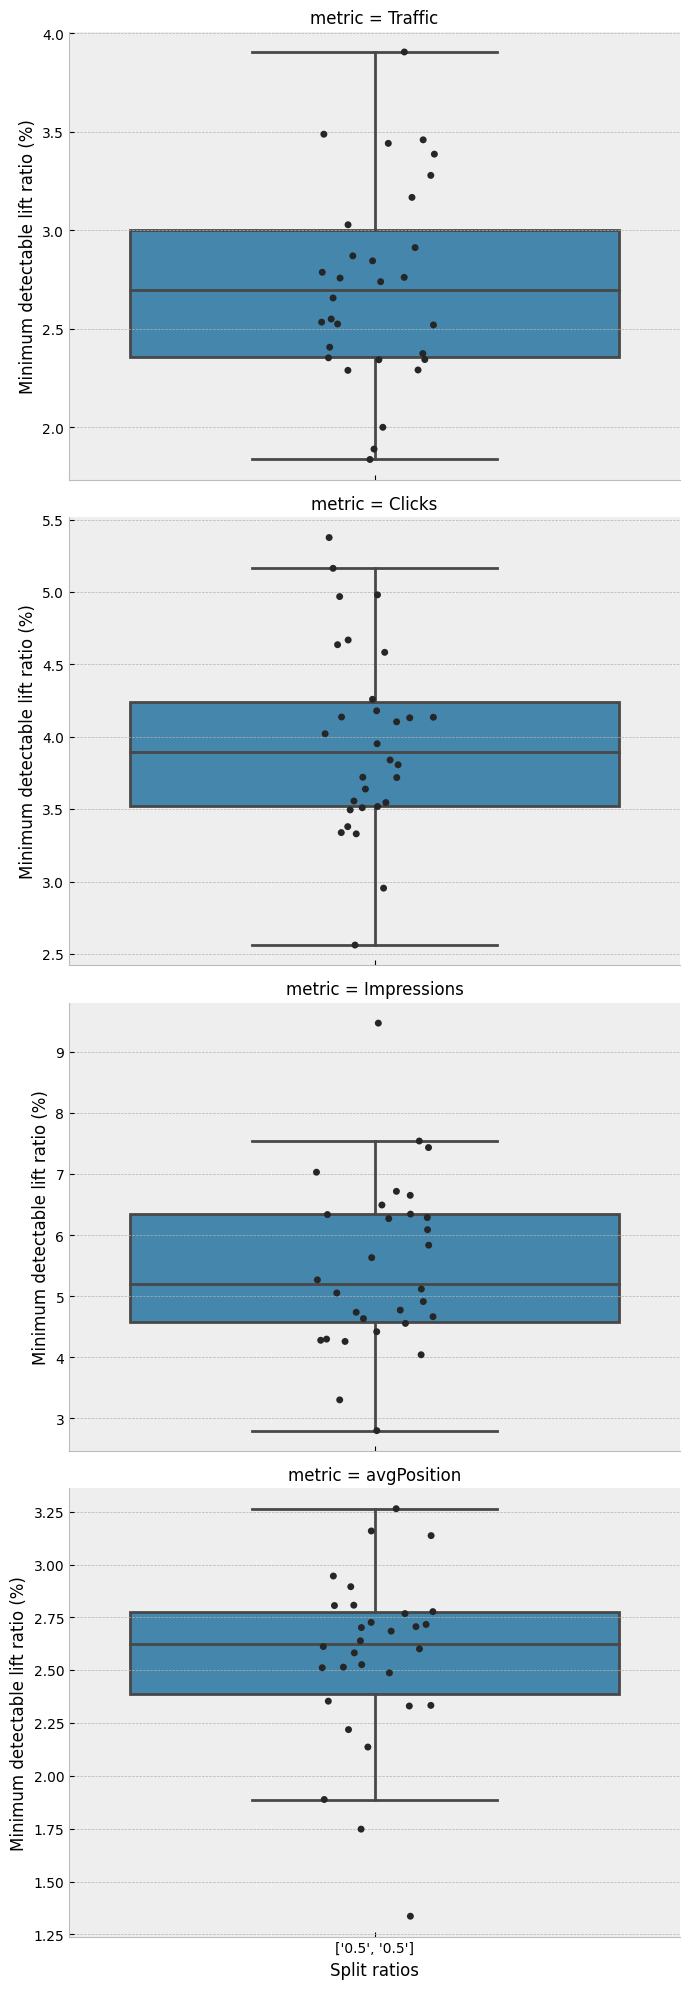

In [183]:
plot_mdlr = sns.catplot(
    x="split_ratios", y='mdlr', col='metric', data=measurement_summary,
    kind="box", sharey=False, col_wrap=1, showfliers=False,
    aspect=1.4) 
strp = plot_mdlr.map_dataframe(sns.stripplot, x="split_ratios", y="mdlr", hue='method', dodge=True, palette='dark:gray')
labs = plot_mdlr.set_axis_labels("Split ratios", "Minimum detectable lift ratio (%)")